# 📊 Hybrid Time Series Forecasting Project

This notebook implements a hybrid approach using decomposition and autoregression (AR) to forecast the Nifty 50 index.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

## Step 1: Download Nifty 50 data

In [4]:
nifty = yf.download("^NSEI", start="2020-01-01", end="2024-12-31")
close_prices = nifty['Close'].dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## Step 2: Calculate Daily Returns and RSI

In [5]:
returns = close_prices.pct_change().dropna()

def compute_rsi(data, window=14):
    delta = data.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    gain = up.rolling(window=window).mean()
    loss = down.rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi = compute_rsi(close_prices)

## Step 3: Seasonal Decomposition

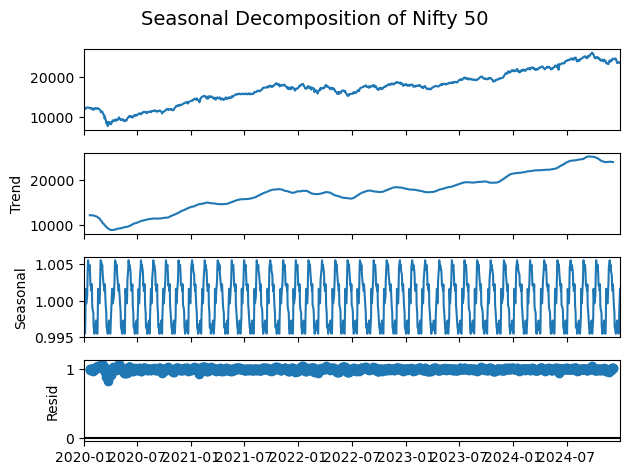

In [6]:
decomp = seasonal_decompose(close_prices, model='multiplicative', period=30)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Visualize decomposition
decomp.plot()
plt.suptitle("Seasonal Decomposition of Nifty 50", fontsize=14)
plt.tight_layout()
plt.show()

## Step 4: Train-test Split on Residuals

In [7]:
residual_clean = residual.dropna()
train_size = int(len(residual_clean) * 0.9)
train_resid = residual_clean[:train_size]
test_resid = residual_clean[train_size:]

## Step 5: ADF Test and ACF/PACF

ADF Statistic (train residual): -9.770147502903152
p-value: 7.17223985242688e-17


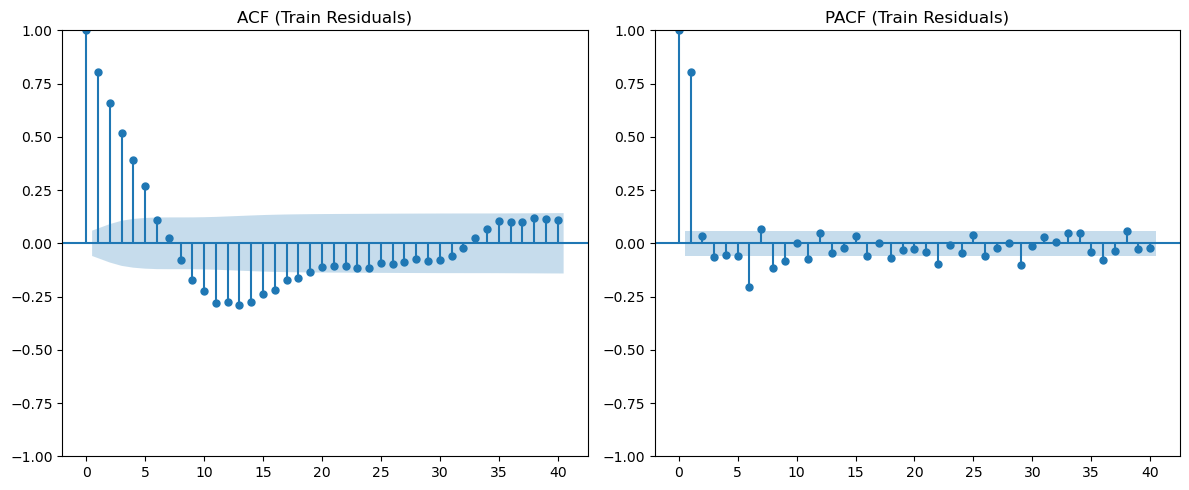

In [8]:
adf_result = adfuller(train_resid)
print("ADF Statistic (train residual):", adf_result[0])
print("p-value:", adf_result[1])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(train_resid, lags=40, ax=plt.gca())
plt.title("ACF (Train Residuals)")

plt.subplot(1, 2, 2)
plot_pacf(train_resid, lags=40, ax=plt.gca(), method='ywm')
plt.title("PACF (Train Residuals)")
plt.tight_layout()
plt.show()

## Step 6: Fit AR Model and Predict

In [9]:
ar_model = AutoReg(train_resid, lags=5).fit()
print(ar_model.summary())

pred_resid = ar_model.predict(start=len(train_resid), end=len(train_resid)+len(test_resid)-1)
pred_resid.index = test_resid.index

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                 1085
Model:                     AutoReg(5)   Log Likelihood                3310.164
Method:               Conditional MLE   S.D. of innovations              0.011
Date:                Sat, 17 May 2025   AIC                          -6606.327
Time:                        21:48:37   BIC                          -6571.434
Sample:                             5   HQIC                         -6593.115
                                 1085                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2241      0.022     10.374      0.000       0.182       0.266
resid.L1       0.7734      0.030     25.467      0.000       0.714       0.833
resid.L2       0.0860      0.038      2.240      0.0

C:\Users\Mohan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Mohan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Mohan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Mohan\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will co

## Step 7: Visualize Forecast vs Actual

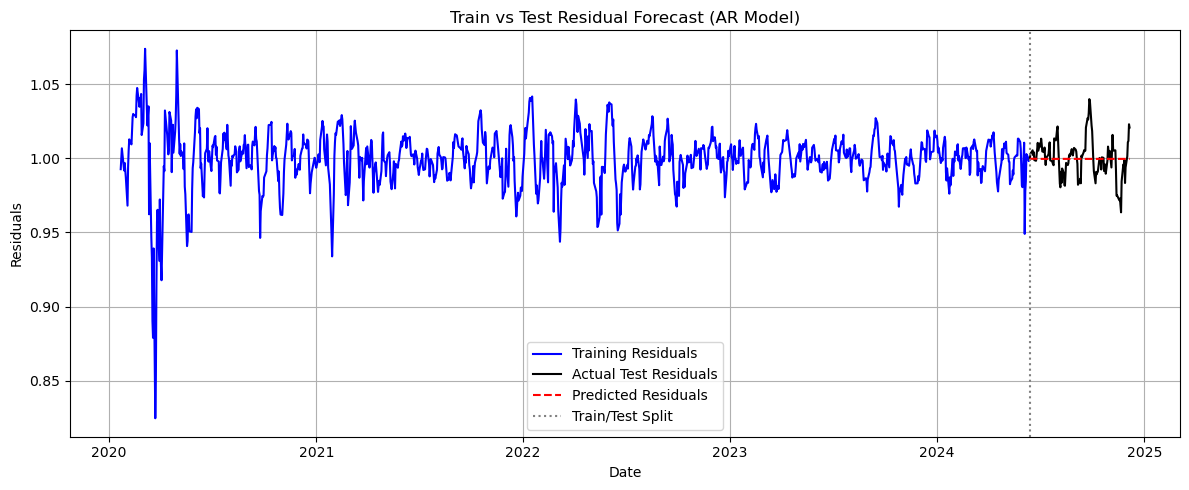

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(train_resid.index, train_resid, label='Training Residuals', color='blue')
plt.plot(test_resid.index, test_resid, label='Actual Test Residuals', color='black')
plt.plot(pred_resid.index, pred_resid, label='Predicted Residuals', color='red', linestyle='--')
plt.axvline(test_resid.index[0], color='gray', linestyle=':', label='Train/Test Split')
plt.title("Train vs Test Residual Forecast (AR Model)")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 8: Reconstruct and Plot Forecasted Price

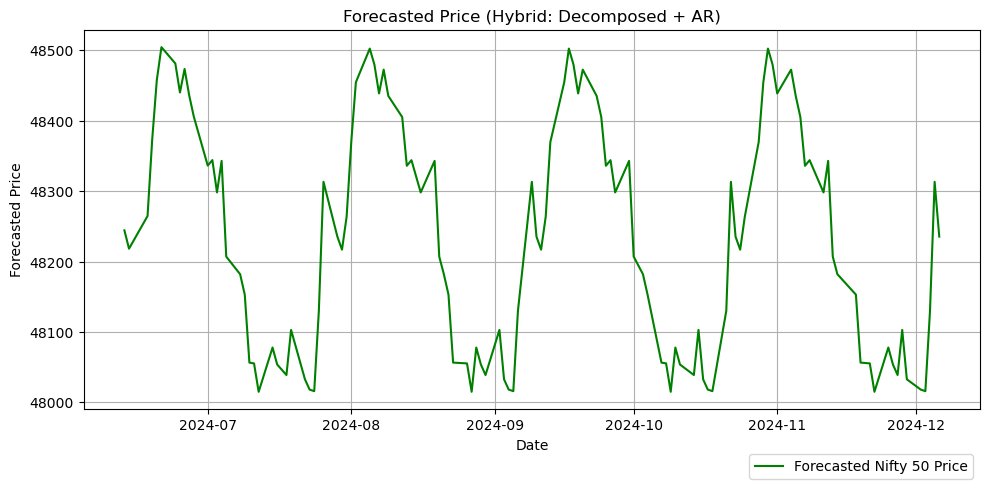

In [12]:
valid_trend = trend.dropna()
last_trend_value = valid_trend.iloc[-1]
seasonal_pattern = seasonal[-30:].values
seasonal_future = np.tile(seasonal_pattern, int(np.ceil(len(pred_resid)/30)))[:len(pred_resid)]
reconstructed_price = last_trend_value * seasonal_future * (1 + pred_resid.values)

plt.figure(figsize=(10, 5))
plt.plot(pred_resid.index, reconstructed_price, label='Forecasted Nifty 50 Price', color='green')
plt.title("Forecasted Price (Hybrid: Decomposed + AR)")
plt.xlabel("Date")
plt.ylabel("Forecasted Price")
plt.grid(True)
plt.legend(bbox_to_anchor = (1,-0.1))
plt.tight_layout()
plt.show()

## Step 9: Fetch and Plot Actual Price VS Forecasted Price

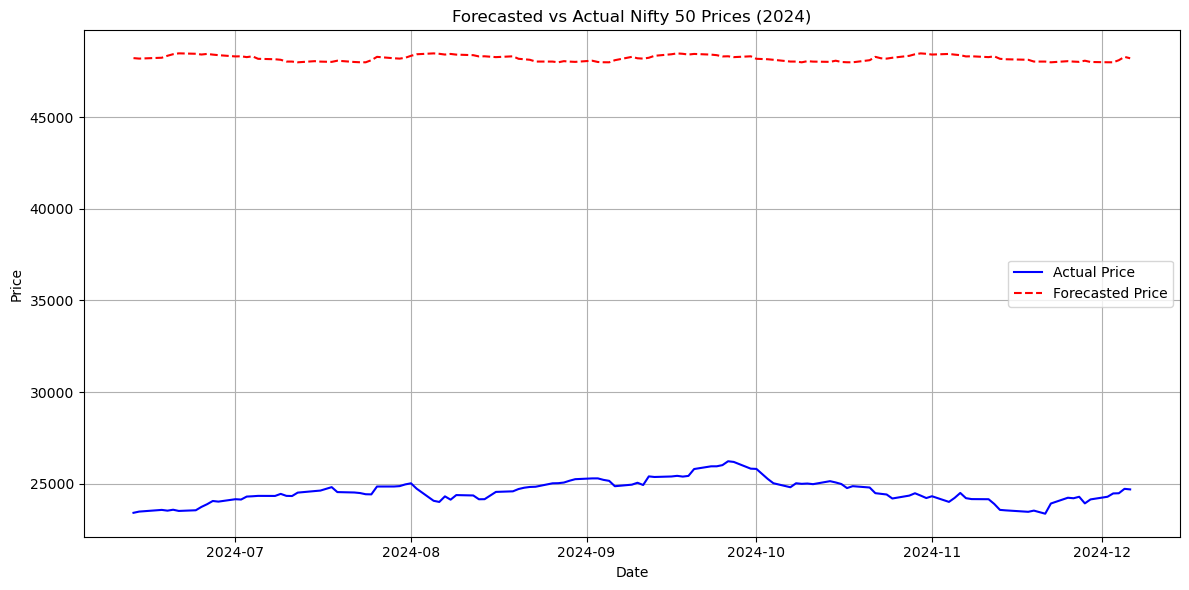

In [13]:
actual_prices = close_prices[pred_resid.index.min():pred_resid.index.max()]
actual_prices = actual_prices.loc[pred_resid.index]

plt.figure(figsize=(12,6))
plt.plot(actual_prices.index, actual_prices.values, label='Actual Price', color='blue')
plt.plot(pred_resid.index, reconstructed_price, label='Forecasted Price', color='red', linestyle='--')
plt.title("Forecasted vs Actual Nifty 50 Prices (2024)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()